In [586]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial import ConvexHull

In [587]:
meta = pd.read_csv('songs_metadata.csv', index_col=0)
df   = pd.read_csv('songs_features.csv', index_col=0)
artist = pd.read_csv('artist_features.csv', index_col=0)

In [588]:
artist = artist.rename(columns={
    'genres':'artist_genres',
    'popularity':'artist_popularity',
    'followers':'artist_followers'
    })

meta = meta.rename(columns={
    'popularity':'song_popularity'
    })

In [589]:
df = df.merge(
        meta, 
        left_on='id',
        right_on='song_id',
        how='left')

df = df.merge(
        artist, 
        on='artist_uri',
        how='left',
        suffixes=['_song','_artist'])

In [590]:
df = df[['song_name', 'artist', 'album',
       'realese_date',
       'danceability', 'energy', 'key', 
       'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 
       'liveness', 'valence', 'tempo',
       'duration_ms', 'song_popularity', 'artist_genres',
       'artist_popularity', 'artist_followers']]

In [591]:
df['artist_genres'] = df['artist_genres'].apply(lambda x: x.\
    replace("['","").replace("']","").replace("'","").split(','))

In [592]:
df['release_year'] = df['realese_date'].apply(lambda x: int(x.split('-')[0]))
df = df.drop(columns=['realese_date'])
df = df.drop_duplicates(subset='song_name')

In [593]:
df.shape

(291, 20)

---

# Prepro

In [594]:
df_num = df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'song_popularity',
       'artist_popularity', 'artist_followers']]

In [595]:
esc = StandardScaler()
df_esc = esc.fit_transform(df_num)

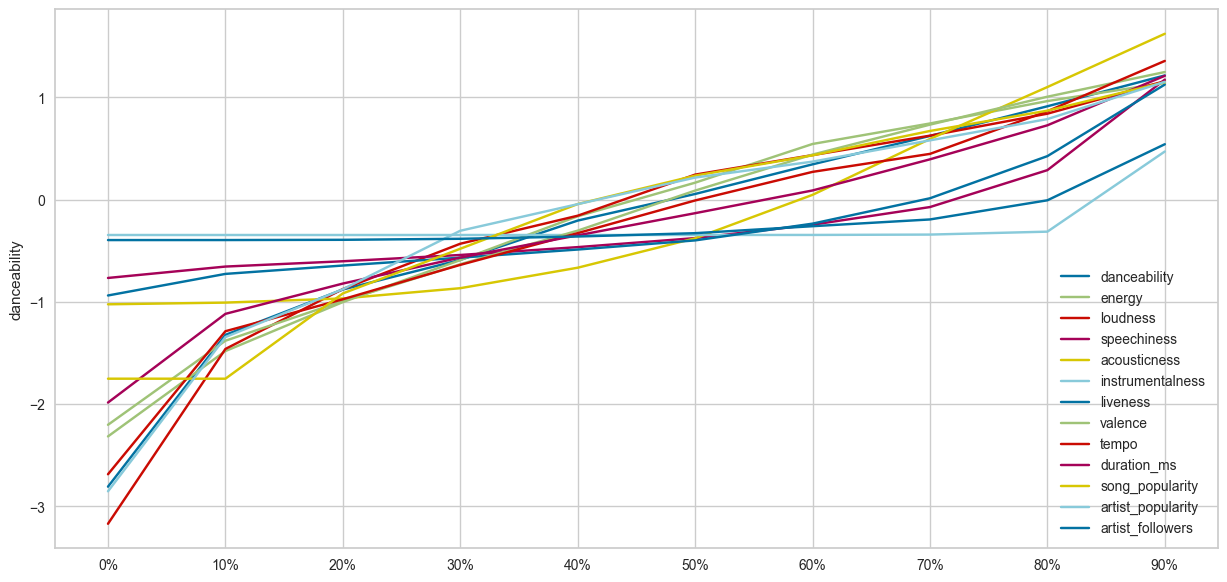

In [596]:
df_percentiles = pd.DataFrame(df_esc, columns=df_num.columns).describe(percentiles=[x for x in np.arange(0,1,.1)]).iloc[4:14,:]
plt.figure(figsize=(15,7))
for col in df_percentiles:
    sns.lineplot(df_percentiles[col], label=col)
    plt.legend()

In [597]:
pca = PCA(n_components=.90)
df_pca = pca.fit_transform(df_esc)

In [598]:
#50% de las variables explican 90% de la varianza
len(pca.explained_variance_) / df.shape[1], len(pca.explained_variance_)

(0.45, 9)

<AxesSubplot: >

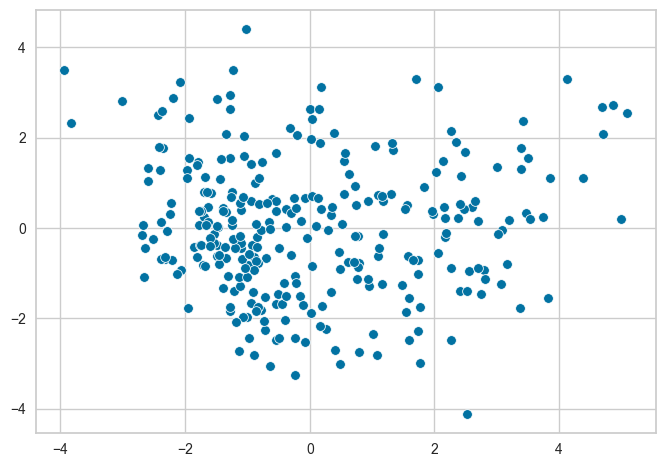

In [599]:
sns.scatterplot(
    x=df_pca[:,0],
    y=df_pca[:,1]
)

In [600]:
kpca = KernelPCA(n_components=10, kernel='sigmoid', gamma=2, random_state=42)
df_kpca = kpca.fit_transform(df_esc)

<AxesSubplot: >

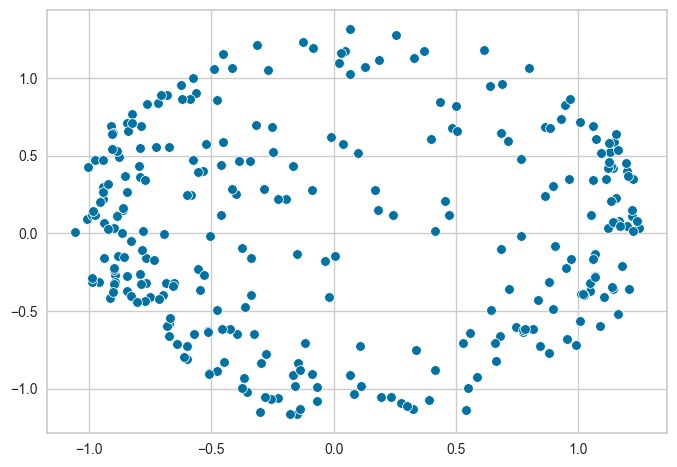

In [601]:
sns.scatterplot(
    x=df_kpca[:,0],
    y=df_kpca[:,1]
)

----

# KMEANS

In [628]:
silohuette = []
inercia    = []
silohuette_kpca = []
inercia_kpca    = []
calinski_harabasz_kpca = []
for i in range(2,10):
    km = KMeans(n_clusters=i, n_init=100, max_iter=1000, random_state=42)
    labels_ = km.fit_predict(df_pca)
    silohuette.append(silhouette_score(df_pca, labels_))
    inercia.append(km.inertia_)

    km = KMeans(n_clusters=i, n_init=100, max_iter=1000, random_state=42)
    labels_ = km.fit_predict(df_kpca)
    silohuette_kpca.append(silhouette_score(df_kpca, labels_))
    inercia_kpca.append(km.inertia_)
    calinski_harabasz_kpca.append(calinski_harabasz_score(df_kpca, labels_))

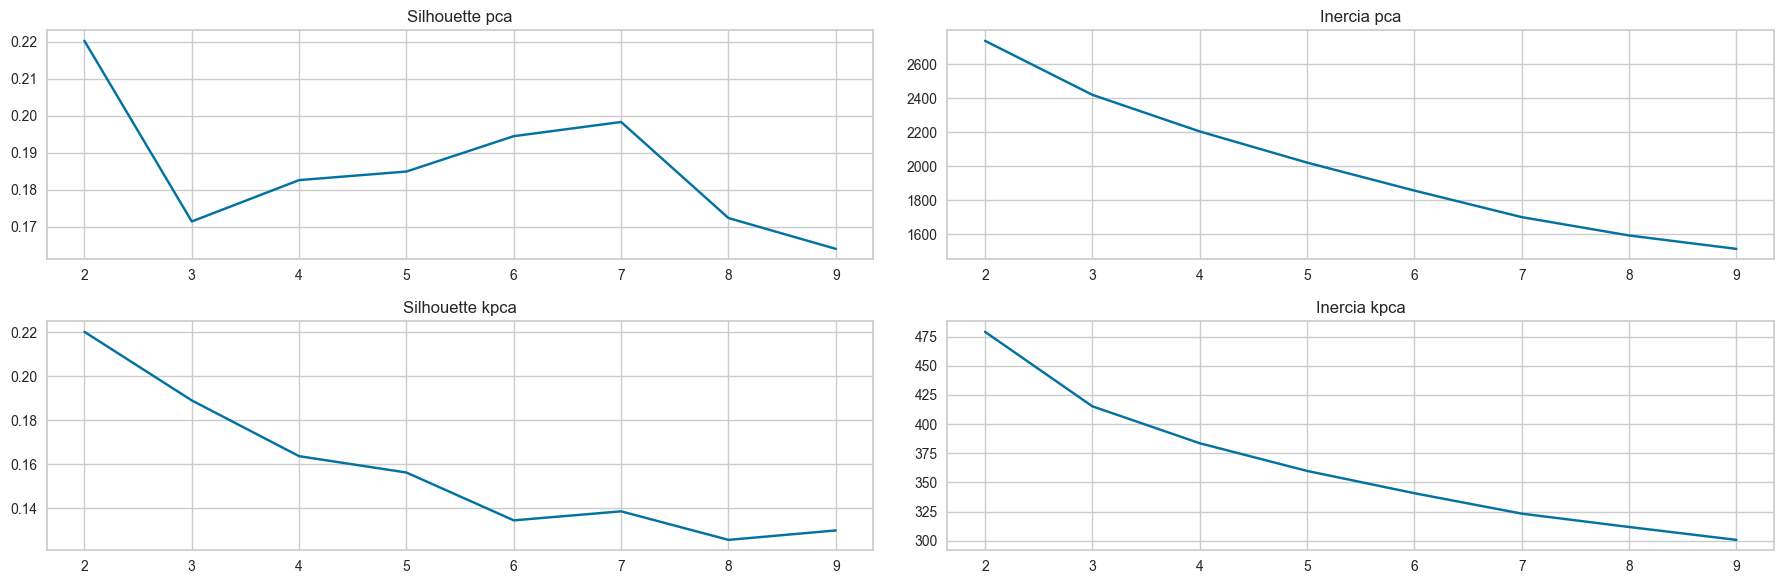

In [629]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(18,6))
sns.lineplot(silohuette, ax=ax[0][0])
sns.lineplot(inercia, ax=ax[0][1])
ax[0][1].set_xticks(ticks=range(0,8),labels=range(2,10))
ax[0][0].set_xticks(ticks=range(0,8),labels=range(2,10))
ax[0][0].set_title('Silhouette pca')
ax[0][1].set_title('Inercia pca');

sns.lineplot(silohuette_kpca, ax=ax[1][0])
sns.lineplot(inercia_kpca, ax=ax[1][1])
ax[1][1].set_xticks(ticks=range(0,8),labels=range(2,10))
ax[1][0].set_xticks(ticks=range(0,8),labels=range(2,10))
ax[1][0].set_title('Silhouette kpca')
ax[1][1].set_title('Inercia kpca');
plt.tight_layout(w_pad=2)

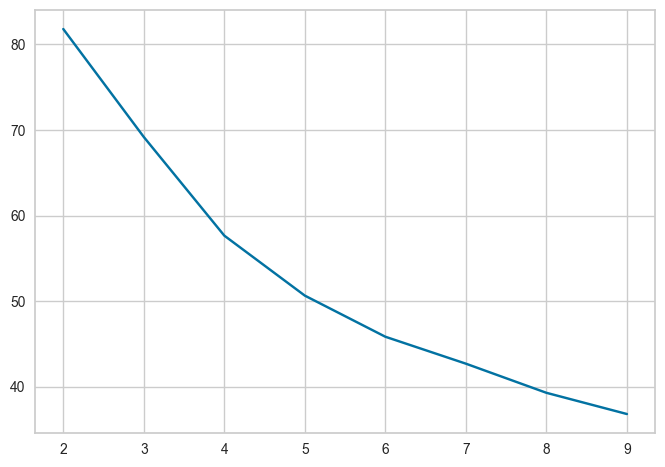

In [604]:
sns.lineplot(calinski_harabasz_kpca)
plt.xticks(ticks=range(0,8),labels=range(2,10));

SilhouetteVisualizer(ax=<AxesSubplot: >, colors='yellowbrick',
                     estimator=KMeans(max_iter=1000, n_clusters=3, n_init=100,
                                      random_state=42))

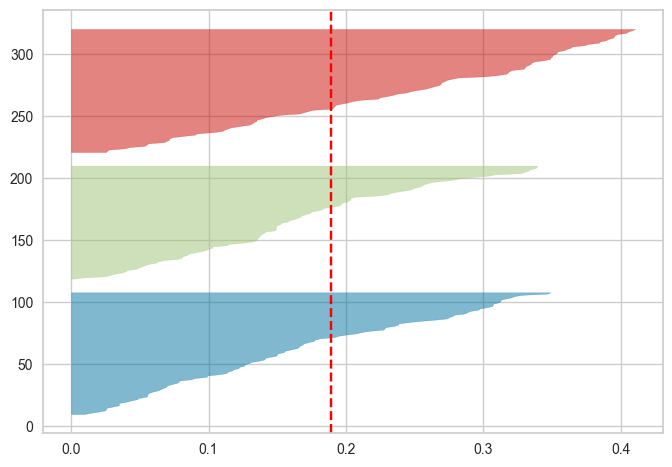

In [605]:
km = KMeans(n_clusters=3, n_init=100, max_iter=1000, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
labels_km = km.fit_predict(df_kpca)
visualizer.fit(df_kpca)

InterclusterDistance(ax=<AxesSubplot: >,
                     estimator=KMeans(max_iter=1000, n_clusters=3, n_init=100,
                                      random_state=42))

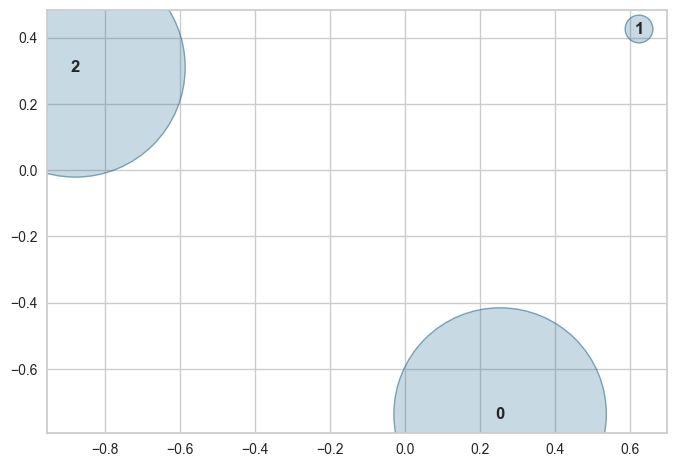

In [606]:
visualizer = InterclusterDistance(km)
visualizer.fit(df_kpca)

In [607]:
silohuette_kpca.extend(silohuette)
top_silhouette_kmeans = np.max(silohuette_kpca)
top_silhouette_kmeans

0.22030795316713017

In [608]:
top_calinski_harabasz_kmeans = calinski_harabasz_score(df_kpca, labels_km)
top_calinski_harabasz_kmeans

69.17958904843758

<AxesSubplot: >

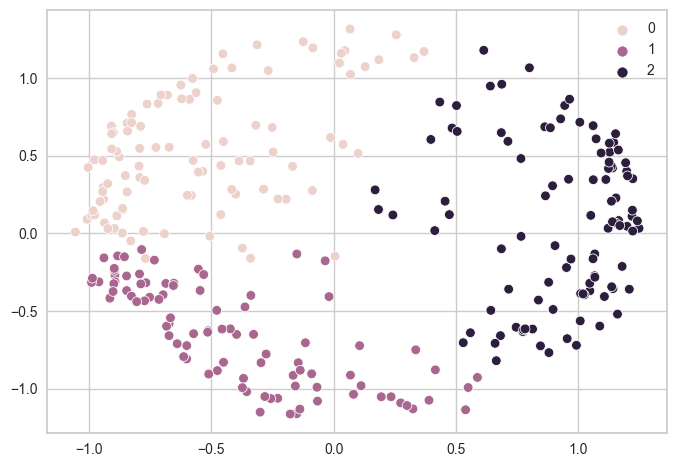

In [609]:
sns.scatterplot(
    x=df_kpca[:,0],
    y=df_kpca[:,1],
    hue=labels_km
)

In [610]:
pd.Series(labels_km).value_counts()

2    100
0     99
1     92
dtype: int64

----

# Gaussian Mixture

In [611]:
from sklearn.mixture import GaussianMixture

In [612]:
k = 20
list_bic_pca = []
list_bic_kpca = []
silohuette = []
silohuette_kpca = []

for n_cluster in np.arange(2,k):
    gmm = GaussianMixture(n_components=n_cluster, n_init=50,covariance_type= "full", random_state=42).fit(df_pca)
    list_bic_pca.append(gmm.bic(df_pca))
    silohuette.append(silhouette_score(df_pca, gmm.fit_predict(df_pca)))

    gmm = GaussianMixture(n_components=n_cluster, n_init=50,covariance_type= "full", random_state=42).fit(df_kpca)
    list_bic_kpca.append(gmm.bic(df_kpca))
    silohuette_kpca.append(silhouette_score(df_kpca, gmm.fit_predict(df_kpca)))

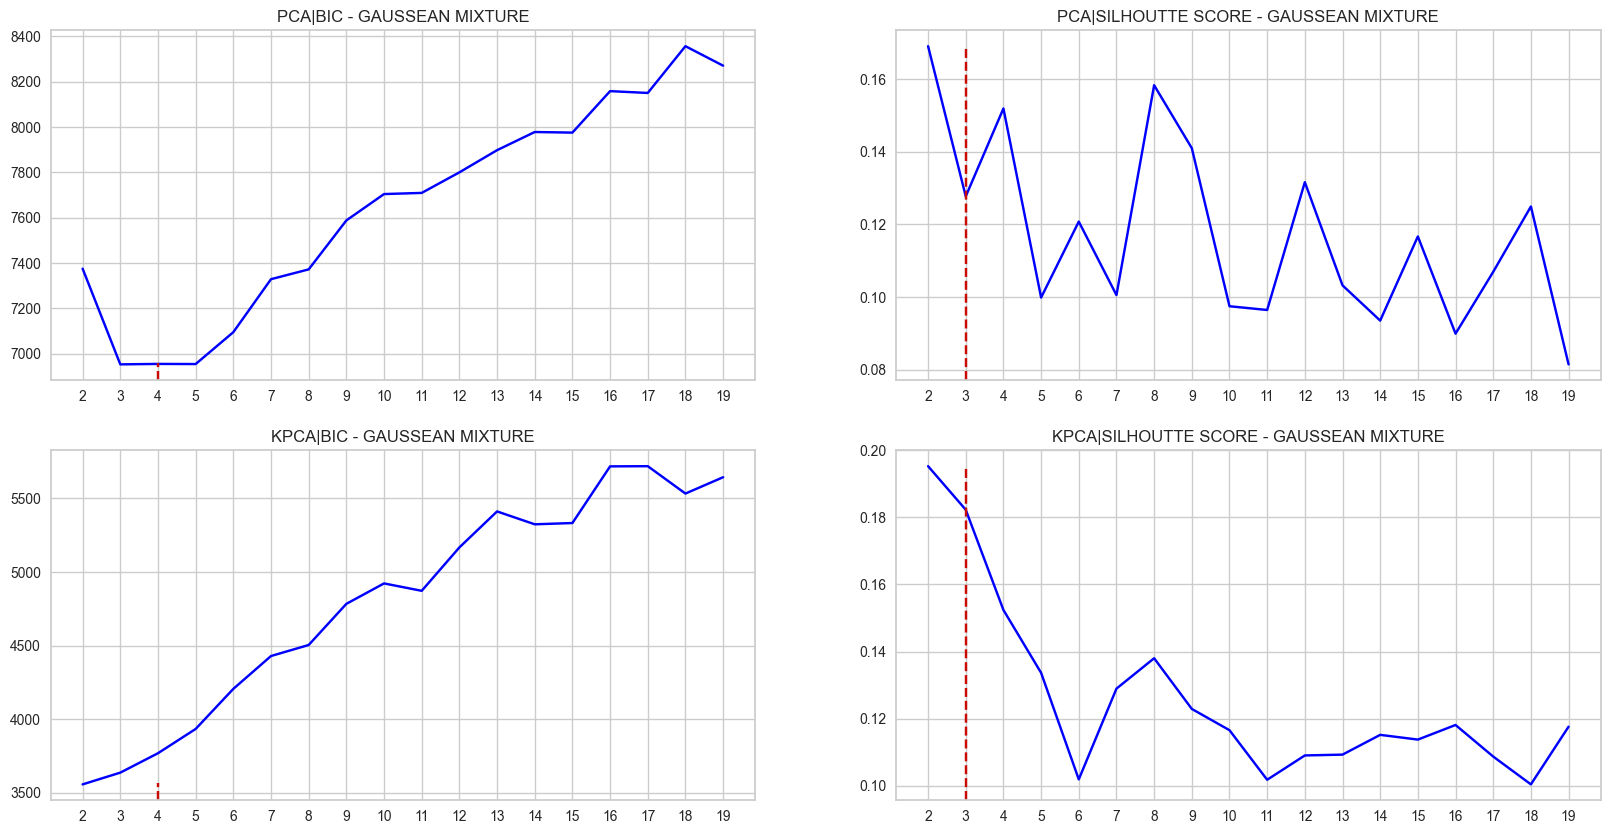

In [613]:
fig2, ax2 = plt.subplots(2,2, figsize=(20,10))

g1=sns.lineplot(x=np.linspace(2, 19, 18), y=list_bic_pca, ax = ax2[0][0], color = "blue")
g1.axvline(x = 4, color = "r", linestyle='--', ymin = 0, ymax=0.05)
g1.set_xticks(np.linspace(2, 19, 18))
g1.set_title("PCA|BIC - GAUSSEAN MIXTURE")

g2 = sns.lineplot(x=np.linspace(2, 19, 18), y=silohuette, ax = ax2[0][1], color = "blue")
g2.axvline(x = 3, color = "r", linestyle='--', ymin = 0, ymax=0.95)
g2.set_xticks(np.linspace(2, 19, 18))
g2.set_title("PCA|SILHOUTTE SCORE - GAUSSEAN MIXTURE");


g3=sns.lineplot(x=np.linspace(2, 19, 18), y=list_bic_kpca, ax = ax2[1][0], color = "blue")
g3.axvline(x = 4, color = "r", linestyle='--', ymin = 0, ymax=0.05)
g3.set_xticks(np.linspace(2, 19, 18))
g3.set_title("KPCA|BIC - GAUSSEAN MIXTURE")

g4 = sns.lineplot(x=np.linspace(2, 19, 18), y=silohuette_kpca, ax = ax2[1][1], color = "blue")
g4.axvline(x = 3, color = "r", linestyle='--', ymin = 0, ymax=0.95)
g4.set_xticks(np.linspace(2, 19, 18))
g4.set_title("KPCA|SILHOUTTE SCORE - GAUSSEAN MIXTURE");

In [614]:
gm= GaussianMixture(n_components=3, n_init=50,covariance_type= "full", random_state=42)
labels_gm = gm.fit_predict(df_kpca)

In [615]:
silohuette_kpca.extend(silohuette)
top_silhouette_gm = np.max(silohuette_kpca)
top_silhouette_gm

0.1952756860161648

In [616]:
top_calinski_harabasz_gm = calinski_harabasz_score(df_kpca, labels_gm)
top_calinski_harabasz_gm

61.47190815016838

----

# DBSCANN

In [617]:
silohuette = []
silohuette_kpca = []
for i in np.arange(1,10,.5):
    for k in range(3,6):
        try:
            gm = DBSCAN(eps=i, min_samples=k)
            labels_ = gm.fit_predict(df_pca)
            silohuette.append((i,k,silhouette_score(df_pca, labels_)))

            gm = DBSCAN(eps=i, min_samples=k)
            labels_ = gm.fit_predict(df_kpca)
            silohuette_kpca.append((i,k,silhouette_score(df_kpca, labels_)))
        except:
            pass

In [618]:
maximo = np.argmax(np.array(silohuette)[:,2])
silohuette[maximo]

(4.0, 3, 0.45450630463046704)

<AxesSubplot: >

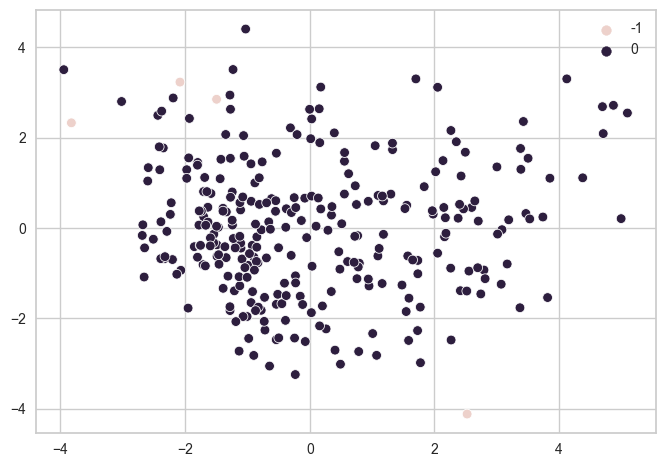

In [619]:
gm = DBSCAN(eps=4, min_samples=3)
labels_db = gm.fit_predict(df_pca)
sns.scatterplot(
    x=df_pca[:,0],
    y=df_pca[:,1],
    hue=labels_db
)

In [623]:
aux1 = [x[2] for x in silohuette_kpca]
aux2 = [x[2] for x in silohuette]
aux1.extend(aux2)
top_silhouette_db = np.max(aux1)
top_silhouette_db

0.45450630463046704

In [624]:
top_calinski_harabasz_db = calinski_harabasz_score(df_kpca, labels_db)
top_calinski_harabasz_db

2.7327684894228423

In [625]:
pd.Series(labels_db).value_counts()

 0    287
-1      4
dtype: int64

----

# Spectral

In [ ]:
silohuette = []
silohuette_kpca = []
for i in range(2,6):
    for k in range(2,5):
        for m in ['rbf','nearest_neighbors']:
            try:
                sc = SpectralClustering(n_clusters=k, n_components=i, affinity=m, random_state=42)
                labels_ = sc.fit_predict(df_pca)
                silohuette.append((i,k,m,silhouette_score(df_pca, labels_)))

                sc = SpectralClustering(n_clusters=k, n_components=i, affinity=m, random_state=42)
                labels_ = sc.fit_predict(df_kpca)
                silohuette_kpca.append((i,k,m,silhouette_score(df_kpca, labels_)))
            except:
                pass

In [ ]:
maximo = np.argmax(np.array(silohuette)[:,2])
silohuette[maximo]

(2, 2, 'rbf', 0.3339034730533304)

In [ ]:
maximo = np.argmax(np.array(silohuette_kpca)[:,2])
silohuette_kpca[maximo]

(2, 2, 'rbf', 0.21956078465869275)

<AxesSubplot: >

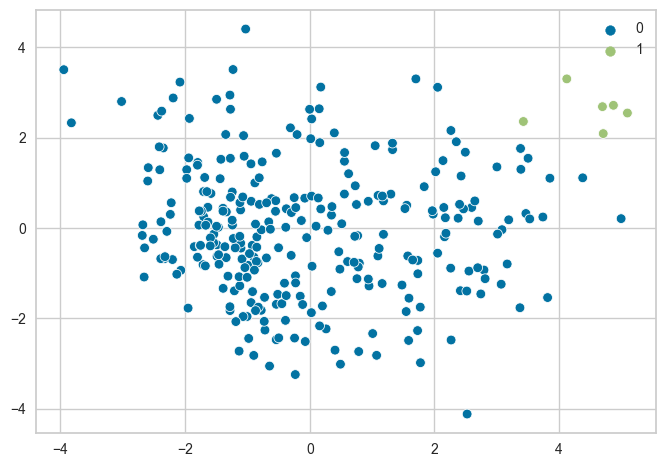

In [ ]:
sc = SpectralClustering(n_clusters=2, n_components=2, affinity='rbf', random_state=42)
labels_sp = sc.fit_predict(df_pca)
sns.scatterplot(
    x=df_pca[:,0],
    y=df_pca[:,1],
    hue=labels_sp
)

In [ ]:
aux1 = [x[3] for x in silohuette_kpca]
aux2 = [x[3] for x in silohuette]
aux1.extend(aux2)
top_silhouette_esp = np.max(aux1)
top_silhouette_esp

0.3339034730533304

In [ ]:
top_calinski_harabasz_esp = calinski_harabasz_score(df_kpca, labels_sp)
top_calinski_harabasz_esp

5.81680908578096

In [ ]:
pd.Series(labels_sp).value_counts()

0    285
1      6
dtype: int64

---

# Análisis

In [ ]:
df['labels'] = labels_km

In [ ]:
df[df.labels==0].sample(10).song_name

392    Sobreviviendo (with Victor Heredia)
85         Beelzeboss (The Final Showdown)
341                              Alejandro
228                Wonderwall - Remastered
213              El Pibe de los Astilleros
408               Dreams (Will Come Alive)
352                                Je veux
243                             Queso Ruso
498                          Snow (Hey Oh)
546                                   Halo
Name: song_name, dtype: object

In [ ]:
df[df.labels==1].sample(10).song_name

326                          ¡Cuidado La Bomba!
346                                   Duraznito
453                      Poco Asado, Mucho Humo
267                               Si Vos Queres
161                             Nunca me Faltes
103                     Jolene - Dumplin' Remix
131                          We Built This City
12     El Humahuaqueño / Carnavalito Quebradeño
511                               Canto Nochero
538                               El Coya Dance
Name: song_name, dtype: object

In [ ]:
df[df.labels==2].sample(10).song_name

89             Somebody to Love
41                   Viva Jujuy
539    Les crevettes pailletées
29                       La Oma
474               Busindre Reel
297    Non, je ne regrette rien
289              La vie en rose
462                   El Sensei
301       Rock And Roll Part II
182                   I'm Alive
Name: song_name, dtype: object

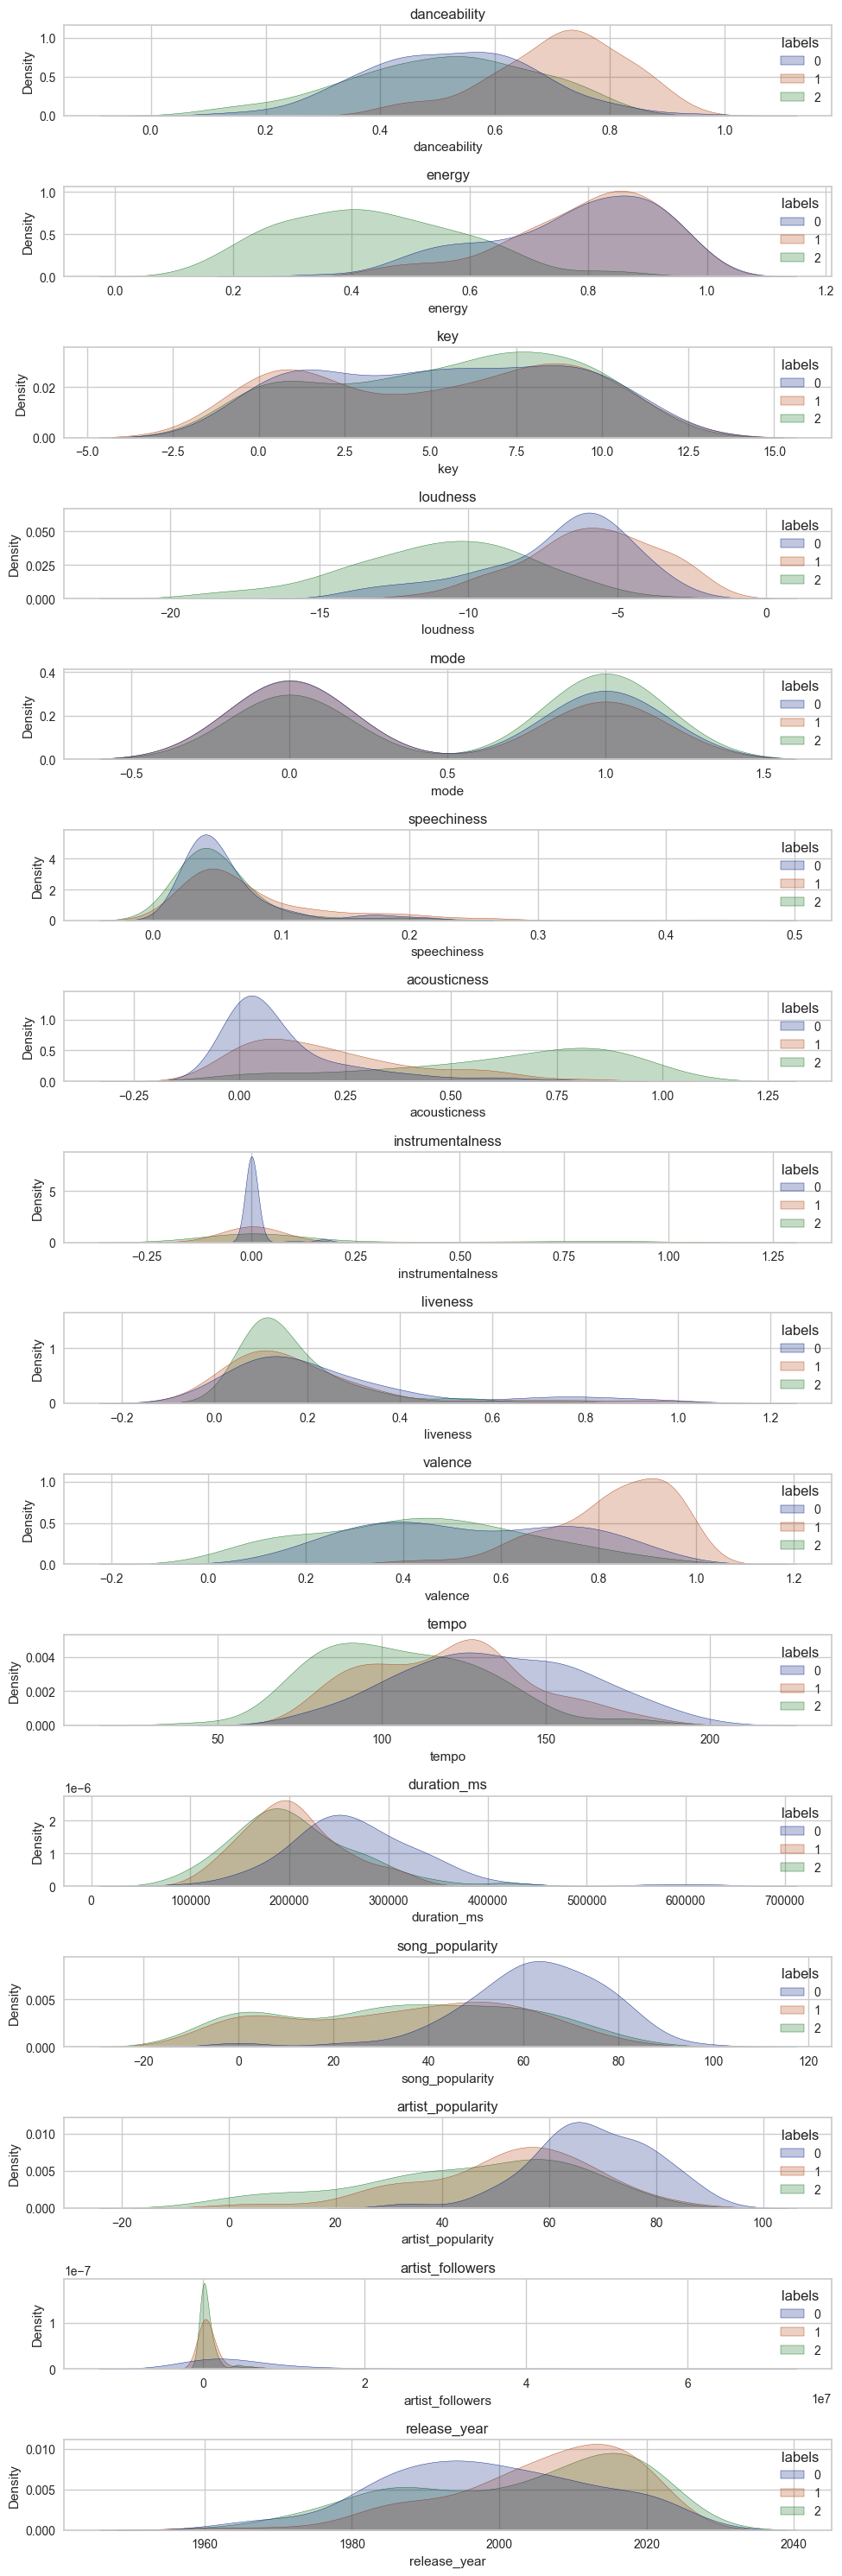

In [ ]:
fig, axes = plt.subplots(nrows=16, ncols=1, figsize=(10,30))
for axs, col in zip(axes, df.select_dtypes(exclude='O').drop(columns=['labels']).columns):
    sns.kdeplot(
        x=col,
        data=df,
        hue='labels',
        fill=True, 
        ax=axs,
        palette='dark')
    axs.set_title(col)
plt.tight_layout()

In [ ]:
df.groupby('labels').mean()

C:\Users\nicolas.dominutti_ro\AppData\Local\Temp\ipykernel_14756\1373012106.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('labels').mean()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
labels,,,,,,,,,,,,,,,,
0,0.523808,0.774222,5.393939,-7.060333,0.464646,0.058519,0.110617,0.010501,0.259855,0.537465,134.365212,269912.656566,61.868687,68.101010,6.411408e+06,1998.333333
1,0.710652,0.797065,5.250000,-5.876130,0.423913,0.077945,0.217996,0.051789,0.205310,0.826478,120.672685,203710.684783,35.065217,51.630435,1.012711e+06,2005.673913
2,0.508210,0.433990,5.550000,-10.912160,0.570000,0.059052,0.621552,0.159671,0.179982,0.437493,106.051720,205533.020000,34.750000,44.660000,6.974076e+05,2002.810000


1er cluster:
* son las canciones menos acústicas
* poco instrumentales
* son las que tienen mayor componente de liveness
* son las más aceleradas en tempo
* son las canciones y artistas más populares
* canciones más viejas según año de release
* es un cluster con gran componente de Rock, tanto local como internacional

2do cluster: 
* alta danzabilidad
* alta energía
* alto sonido
* mayor speechiness
* alta valencia
* son las más nuevas según año de release
* cluster con un gran componente de canciones de cumbia, tiene un componente<br>
interesante de artistas de los cuales no tenemos género, siendo ellos:<br>
The Harmony Group, Hebras, La Banda Dominguera, Raphael, Gliese, Ricky Maravilla, <br>
Standy, El Jarra, Gladys "La bomba tucumana", Dik Lewis, Romain Brau<br><br>
Vemos que algunos como Gladys "La bomba tucumana" o Ricky Maravilla condicen con<br>
la pauta de un cluster orientado a la música tropical y latina.<br>

3er cluster:
* baja danzabilidad
* baja energía
* bajo sonido
* son muy acústicas
* altamente instrumentales
* de estudio más que live
* baja valencia
* un tempo tranquilo
* son las que tienen menor popularidad (canción y artista)<br>
* quizá el menos caracterizado en cuanto al género, tiene presencia del rock
como en el cluster 1, pero también presenta una gran incidencia de los artistas
de los cuales no tenemos género, como son: Gerardo Matos Rodriguez, Angelica Vale, 
Angel Mahler, Jekyll Hyde, Hyde, The Dream All Stars, Johnny Thunder, Giuseppe Turco, 
Cristina Zivec, Gary Glitter, Marty McFly, Rodrigo Montero, Will Ferrell, Various Artists,
Orquesta de Pulso y Pua de la Universidad Complutense de Madrid, Lovecraft Country Cast, 
simonbrito.dj, Rocío Sanjurjo Abalos, Ennio Morricone, Elena Roger, Frédéric Kooshmanian.

Artistas de cada grupo, ¿hay coincidencias?

In [ ]:
artistas_grupo0 = df.groupby('labels').artist.unique()[0]
artistas_grupo1 = df.groupby('labels').artist.unique()[1]
artistas_grupo2 = df.groupby('labels').artist.unique()[2]

In [ ]:
#grupos0 y 1 tienen mayor cantidad de coincidencias de artistas, pero no es tanta

In [683]:
print('Overlap de artistas entre cluster 1 y 2')
print(f'Artistas en el overlap: {list(set(artistas_grupo0).intersection(set(artistas_grupo1)))[:4]}'),\
    print(list(set(artistas_grupo0).intersection(set(artistas_grupo1)))[4:]),\
    print(f'% de overlap sobre cluster 1: {round(len(set(artistas_grupo0).intersection(set(artistas_grupo1)))/artistas_grupo0.shape[0],2)}'),\
    print(f'% de overlap sobre cluster 2: {round(len(set(artistas_grupo0).intersection(set(artistas_grupo1)))/artistas_grupo1.shape[0],2)}');

Overlap de artistas entre cluster 1 y 2
Artistas en el overlap: ['Rod Stewart', 'Damas Gratis', 'The Weather Girls', 'Onda Sabanera']
['Patricio Rey y sus Redonditos de Ricota', 'Madonna', 'Bizarrap', 'Billy Joel', 'Tina Turner']
% de overlap sobre cluster 1: 0.13
% de overlap sobre cluster 2: 0.12


In [677]:
print('Overlap de artistas entre cluster 1 y 3')
print(f'Artistas en el overlap: {set(artistas_grupo0).intersection(set(artistas_grupo2))}'),\
    print(f'% de overlap sobre cluster 1: {round(len(set(artistas_grupo0).intersection(set(artistas_grupo2)))/artistas_grupo0.shape[0],2)}'),\
    print(f'% de overlap sobre cluster 3: {round(len(set(artistas_grupo0).intersection(set(artistas_grupo2)))/artistas_grupo2.shape[0],2)}');

Overlap de artistas entre cluster 1 y 3
Artistas en el overlap: {'Billy Joel', 'Survivor', 'Scorpions'}
% de overlap sobre cluster 1: 0.04
% de overlap sobre cluster 3: 0.03


In [684]:
print('Overlap de artistas entre cluster 2 y 3')
print(f'Artistas en el overlap: {list(set(artistas_grupo1).intersection(set(artistas_grupo2)))[:4]}'),\
    print(list(set(artistas_grupo1).intersection(set(artistas_grupo2)))[4:]),\
    print(f'% de overlap sobre cluster 2: {round(len(set(artistas_grupo1).intersection(set(artistas_grupo2)))/artistas_grupo1.shape[0],2)}'),\
    print(f'% de overlap sobre cluster 3: {round(len(set(artistas_grupo1).intersection(set(artistas_grupo2)))/artistas_grupo2.shape[0],2)}');

Overlap de artistas entre cluster 2 y 3
Artistas en el overlap: ["Juan D'Arienzo", 'Victor Heredia', 'The Blues Brothers', 'Billy Joel']
['Dolly Parton', 'Modern Talking']
% de overlap sobre cluster 2: 0.08
% de overlap sobre cluster 3: 0.07


In [685]:
df[df.artist.str.contains('Joel')]

,song_name,artist,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_genres,artist_popularity,artist_followers,release_year
102,Money Money,Joel Grey,Cabaret,0.746,0.690,0,-11.290,1,0.1210,0.7600,0.000000,0.7940,0.780,100.782,183693,0,"[broadway, show tunes]",38,11810,1972
191,The Downeaster 'Alexa',Billy Joel,Greatest Hits Vol. III,0.400,0.812,9,-5.783,0,0.0386,0.1170,0.000000,0.1260,0.607,88.971,222840,25,"[classic rock, mellow gold, piano rock, roc...",77,4653010,1997
196,Somewhere Along the Line,Billy Joel,Piano Man,0.527,0.529,7,-9.692,1,0.0332,0.7000,0.023600,0.0834,0.544,82.324,200000,29,"[classic rock, mellow gold, piano rock, roc...",77,4653010,1973
201,Piano Man,Billy Joel,Piano Man,0.334,0.477,0,-8.806,1,0.0276,0.6180,0.000004,0.3120,0.405,179.239,336200,64,"[classic rock, mellow gold, piano rock, roc...",77,4653010,1973
280,We Didn't Start the Fire,Billy Joel,The Essential Billy Joel,0.711,0.967,7,-5.204,1,0.0474,0.0849,0.000000,0.2450,0.892,145.020,288400,56,"[classic rock, mellow gold, piano rock, roc...",77,4653010,2001
363,All Shook Up,Billy Joel,Collected Additional Masters,0.635,0.832,0,-8.235,1,0.0699,0.5830,0.000014,0.2030,0.878,151.623,128333,38,"[classic rock, mellow gold, piano rock, roc...",77,4653010,2011


In [ ]:
#Billy Joel es el único que está en los 3 grupos
set(artistas_grupo1).intersection(set(artistas_grupo2)).intersection(set(artistas_grupo0))

{'Billy Joel'}

Géneros

In [ ]:
generos = df.explode('artist_genres')[['artist_genres','labels']]
generos['artist_genres'] = generos['artist_genres'].apply(lambda x: x.strip())#.replace('villera',''))

In [ ]:
genero_por_label = generos.groupby(['artist_genres','labels']).value_counts().reset_index(name='cuenta')

In [ ]:
pivot = pd.pivot_table(
            data=genero_por_label,
            index='artist_genres',
            columns='labels',
            values='cuenta'
        ).fillna(0)

In [ ]:
pivot = np.round(pivot.div(pivot.sum(axis=1), axis=0),2)
pivot = pivot.reset_index()

In [ ]:
generos_solo_grupo0 = pivot[pivot[0]==1]
generos_solo_grupo1 = pivot[pivot[1]==1]
generos_solo_grupo2 = pivot[pivot[2]==1]

In [ ]:
generos_solo_grupo0.shape, generos_solo_grupo1.shape, generos_solo_grupo2.shape

((53, 4), (58, 4), (62, 4))

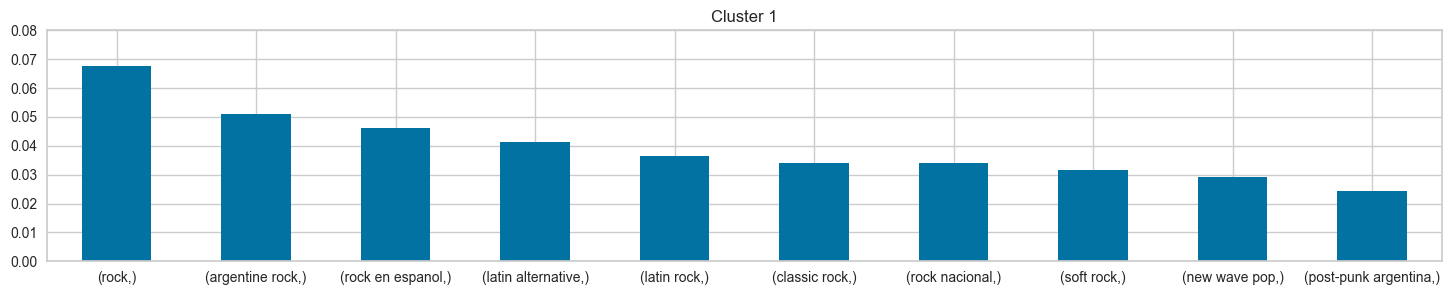

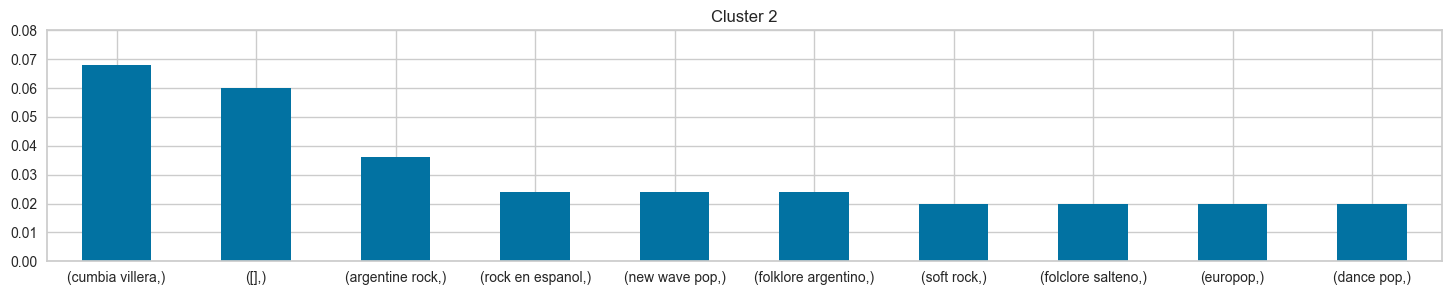

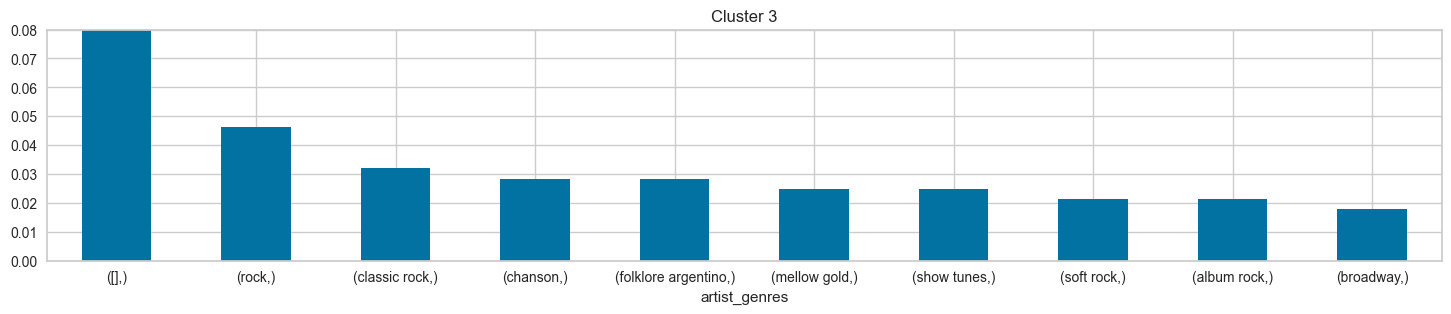

In [669]:
generos[generos.labels==0][['artist_genres']].value_counts(normalize=True).sort_values(ascending=False)[:10].plot(kind='bar', figsize=(18,3),
title='Cluster 1')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylim(0,.08)
plt.figure()
generos[generos.labels==1][['artist_genres']].value_counts(normalize=True).sort_values(ascending=False)[:10].plot(kind='bar', figsize=(18,3),
title='Cluster 2')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylim(0,.08)
plt.figure()
generos[generos.labels==2][['artist_genres']].value_counts(normalize=True).sort_values(ascending=False)[:10].plot(kind='bar', figsize=(18,3),
title='Cluster 3')
plt.xticks(rotation=0)
plt.ylim(0,.08);

In [652]:
aux = df[labels_km==1][['artist','artist_genres']].explode('artist_genres')

In [650]:
list(aux[aux.artist_genres=='[]'].artist.unique())

['Gerardo Matos Rodriguez',
 'Angelica Vale',
 'Angel Mahler',
 'Jekyll Hyde',
 'Hyde',
 'The Dream All Stars',
 'Johnny Thunder',
 'Giuseppe Turco',
 'Cristina Zivec',
 'Gary Glitter',
 'Marty McFly',
 'Rodrigo Montero',
 'Orquesta de Pulso y Pua de la Universidad Complutense de Madrid',
 'Will Ferrell',
 'Various Artists',
 'Lovecraft Country Cast',
 'simonbrito.dj',
 'Rocío Sanjurjo Abalos',
 'Ennio Morricone',
 'Elena Roger',
 'Frédéric Kooshmanian']

In [653]:
", ".join(list(aux[aux.artist_genres=='[]'].artist.unique()))

'The Harmony Group, Hebras, La Banda Dominguera, Raphael, Gliese, Ricky Maravilla, Standy, El Jarra, Gladys "La bomba tucumana", Dik Lewis, Romain Brau'

In [ ]:
generos.groupby('artist_genres').size().sort_values(ascending=False)[:20]

artist_genres
rock                   42
[]                     41
argentine rock         33
rock en espanol        28
classic rock           24
soft rock              24
new wave pop           21
cumbia villera         21
latin alternative      21
rock nacional          21
latin rock             18
mellow gold            17
album rock             16
folklore argentino     14
hard rock              14
dance pop              14
disco                  13
europop                12
post-punk argentina    11
chanson                11
dtype: int64

----

Años de release del tema

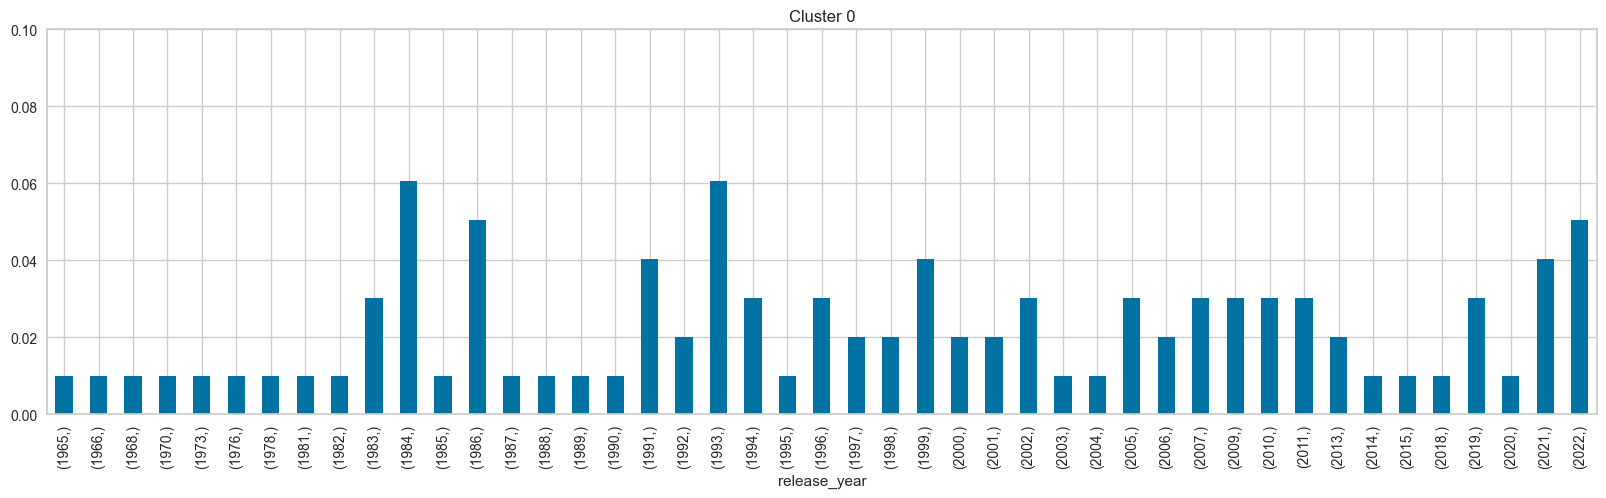

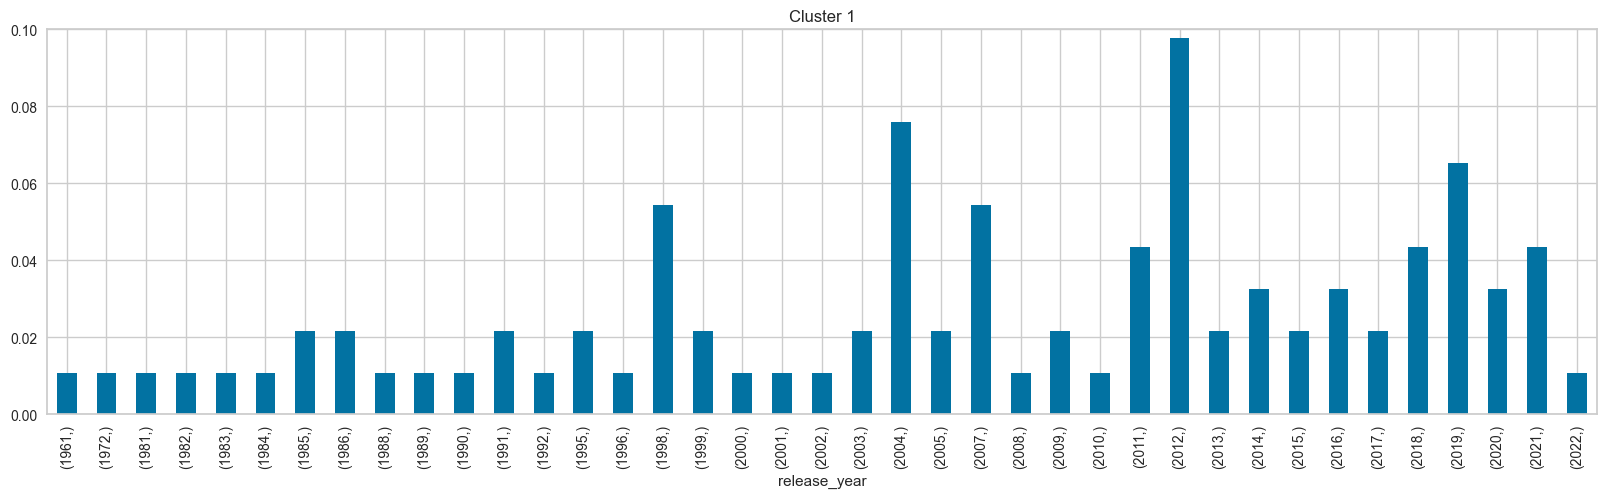

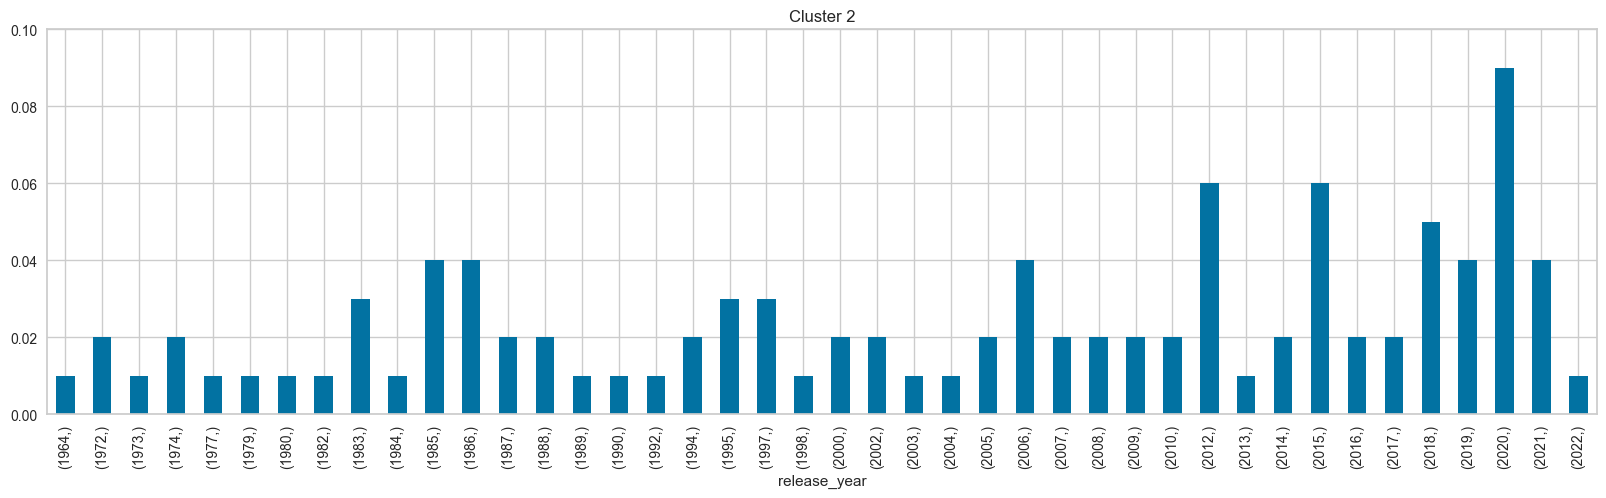

In [ ]:
df[df.labels==0][['release_year']].value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(20,5),
title='Cluster 0')
plt.ylim((0,.1))
plt.figure()
df[df.labels==1][['release_year']].value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(20,5),
title='Cluster 1')
plt.ylim((0,.1))
plt.figure()
df[df.labels==2][['release_year']].value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(20,5),
title='Cluster 2')
plt.ylim((0,.1));

---

In [ ]:
df_kpca = pd.DataFrame(df_kpca, columns=[f'PC_{i}' for i in range(1,11)])

In [ ]:
df_kpca['label'] = labels_km

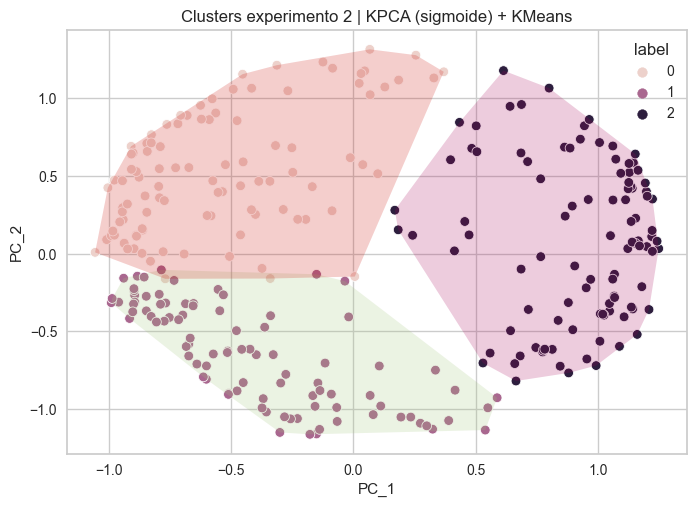

In [ ]:
sns.scatterplot(
    x=df_kpca['PC_1'],
    y=df_kpca['PC_2'],
    hue=df_kpca['label']
)
for i in df_kpca['label'].unique():
    points = df_kpca[df_kpca.label==i][['PC_1','PC_2']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.2)
plt.title('Clusters experimento 2 | KPCA (sigmoide) + KMeans');

In [626]:
#Tabla decomparaciones
leadeboard = pd.DataFrame({
    'método':['K-means','GM','DBSCAN','Espectral'],
    'Silhouette':[
        top_silhouette_kmeans,
        top_silhouette_gm,
        top_silhouette_db,
        top_silhouette_esp
    ],
    'C-H':[
        top_calinski_harabasz_kmeans,
        top_calinski_harabasz_gm,
        top_calinski_harabasz_db,
        top_calinski_harabasz_esp
    ]
})

In [627]:
leadeboard

,método,Silhouette,C-H
0,K-means,0.220308,69.179589
1,GM,0.195276,61.471908
2,DBSCAN,0.454506,2.732768
3,Espectral,0.333903,5.816809
